In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Попробовать нейронку

Добавить ДАМ и найти выбросы

Сделано:

оставить 1 2 3 4 и 7 день

Расширить на весь датасет

Проверить как будет искажаться картинка от 4 до 7 дней

насколько наличие дам улучшает?

Выбросы: История - 2 часа

Предсказывать на 5 минут вперед, классификация (0,1) >200$

In [2]:
df = pd.read_csv('20220715_20220729_PRC_INTVL_LMP_RTM_20220731_05_17_54_v3.csv')
hol = pd.read_csv('HOLLISTR_1_N101.csv')
dam = pd.read_csv('HOLLISTR_1_N101_DAM.csv')

In [3]:
trash = ['NODE_ID_XML', 'NODE_ID', 'NODE', 'MARKET_RUN_ID', 'XML_DATA_ITEM', 'PNODE_RESMRID', 'GRP_TYPE', 'POS']
tr = ['INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT', 'GROUP']
hol.drop(trash, axis=1, inplace=True)
dam.drop(trash, axis=1, inplace=True)
dam.drop(dam[dam.LMP_TYPE == 'MGHG'].index, axis=0, inplace=True)

hol.drop(tr, axis=1, inplace=True)
dam.drop(tr + ['OPR_INTERVAL'], axis=1, inplace=True)
hol['OPR_DT'] =  pd.to_datetime(hol['OPR_DT'], format='%Y-%m-%d')
dam['OPR_DT'] =  pd.to_datetime(dam['OPR_DT'], format='%Y-%m-%d')

Number of outliers > 200$ is
 1122


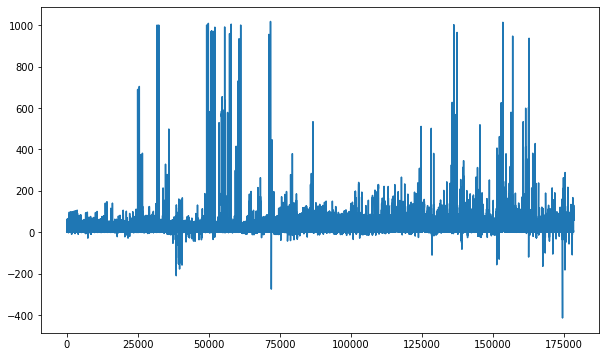

In [4]:
print('Number of outliers > 200$ is\n', (hol.MW > 200).sum())
plt.figure(figsize=(10, 6))
plt.plot(hol.MW);

In [5]:
le = LabelEncoder()
le.fit(['MCC', 'MCE', 'MCL', 'LMP']) 

hol['lmp_trans'] = le.transform(hol.LMP_TYPE)
hol.drop('LMP_TYPE', axis=1, inplace=True)
hol.rename(columns = {'lmp_trans':'LMP_TYPE'}, inplace=True)

dam['lmp_trans'] = le.transform(dam.LMP_TYPE)
dam.drop('LMP_TYPE', axis=1, inplace=True)
dam.rename(columns = {'lmp_trans':'LMP_TYPE'}, inplace=True)

In [6]:
def add_dam(lmp_type, target_date, current_day, hol, dam):
    '''
    Adds DAM to 5-minutes intervals.

    lmp_type - [0, 1, 2, 3] after encoding,
    target_date - '2022-02-07' prediction date,
    current_day - day you are concatenating to,
    hol - HOLLISTR_1_N101.csv after preprocessing,
    dam - HOLLISTR_1_N101_DAM.csv after preprocessing
    '''
    exp = dam[dam['OPR_DT'] == target_date]
    exp = exp[exp['LMP_TYPE'] == lmp_type]  #.sort_values('OPR_HR')
    ee = exp[['OPR_HR', 'MW']]

    sec = hol[hol['OPR_DT'] == current_day]
    sec = sec[sec['LMP_TYPE'] == lmp_type]
    lis = []

    for i in sec['OPR_HR']:
        lis.append(ee[ee['OPR_HR'] == i]['MW'].values)
    sec['dam'] = np.hstack(lis)
    return sec

def train_test(new_df, end_date):
    '''
    
    '''
    test_df = new_df[new_df['OPR_DT'] == end_date]
    test_df.drop(['OPR_DT'], axis=1, inplace=True)
    y_test = test_df['MW']
    X_test = test_df.drop('MW', axis=1)

    train_df = new_df.drop(test_df.index)
    train_df.drop(['OPR_DT'], axis=1, inplace=True)
    y_train = train_df['MW']
    X_train = train_df.drop('MW', axis=1)

    forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='absolute_error')
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    return mean_absolute_error(y_test, y_pred)
    
add_dam(0, '2022-02-07', '2022-02-05', hol, dam)

,OPR_DT,OPR_HR,MW,OPR_INTERVAL,LMP_TYPE,dam
5856,2022-02-05,1,48.43562,1,0,51.04866
5857,2022-02-05,1,49.02668,2,0,51.04866
5858,2022-02-05,1,49.00395,3,0,51.04866
5859,2022-02-05,1,48.91760,4,0,51.04866
5860,2022-02-05,1,48.91760,5,0,51.04866
...,...,...,...,...,...,...
6139,2022-02-05,24,47.99223,8,0,53.23970
6140,2022-02-05,24,47.88387,9,0,53.23970
6141,2022-02-05,24,47.31238,10,0,53.23970
6142,2022-02-05,24,47.31290,11,0,53.23970


In [32]:
def add_dam_new(dates, target_date, hol, dam):
    '''
    Adds DAM to 5-minutes intervals.

    lmp_type - [0, 1, 2, 3] after encoding,
    target_date - '2022-02-07' prediction date,
    current_day - day you are concatenating to,
    hol - HOLLISTR_1_N101.csv after preprocessing,
    dam - HOLLISTR_1_N101_DAM.csv after preprocessing
    '''
    pdList = []
    for n in dates:
        for lmp in [0, 1, 2, 3]:
            exp = dam[dam['OPR_DT'] == target_date]
            exp = exp[exp['LMP_TYPE'] == lmp]  #.sort_values('OPR_HR')
            ee = exp[['OPR_HR', 'MW']]

            sec = hol[hol['OPR_DT'] == n]
            sec = sec[sec['LMP_TYPE'] == lmp]
            lis = []

            for i in sec['OPR_HR']:
                lis.append(ee[ee['OPR_HR'] == i]['MW'].values)
            sec['dam'] = np.hstack(lis)
            pdList.append(sec)

    return pd.concat(pdList)

Classification - detecting outliers > 200$

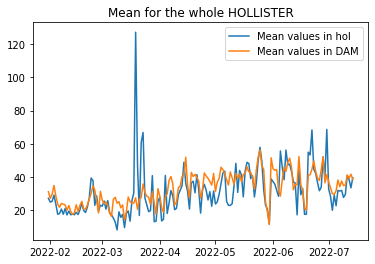

In [7]:
ds_for_damming = dam[(dam['OPR_DT'] >= hol['OPR_DT'].unique()[0]) & (dam['OPR_DT'] <= hol['OPR_DT'].unique()[-1])]   # all dates are as in HOL
hol_max_all = hol.groupby(hol.OPR_DT).mean().MW
dam_max_all = ds_for_damming.groupby(ds_for_damming.OPR_DT).mean().MW

datess = hol['OPR_DT'].unique()
plt.plot(datess, hol_max_all, label='Mean values in hol')
plt.plot(datess, dam_max_all, label='Mean values in DAM')
plt.title('Mean for the whole HOLLISTER')
plt.legend()
plt.show()

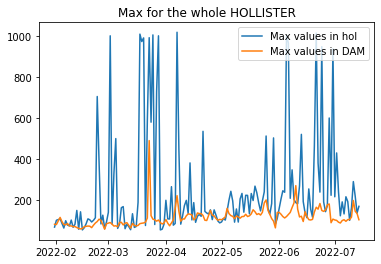

In [8]:
hol_max_all = hol.groupby(hol.OPR_DT).max().MW
dam_max_all = ds_for_damming.groupby(ds_for_damming.OPR_DT).max().MW

datess = hol['OPR_DT'].unique()
plt.plot(datess, hol_max_all, label='Max values in hol')
plt.plot(datess, dam_max_all, label='Max values in DAM')
plt.title('Max for the whole HOLLISTER')
plt.legend()
plt.show()

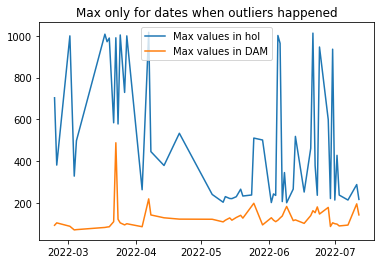

In [9]:
dates_outliers = hol[hol.MW > 200].OPR_DT.unique()
dam_outl, hol_outl = [], []

for d in dates_outliers:
    dam_outl.append(np.max(dam[dam['OPR_DT'] == d].MW))
    hol_outl.append(np.max(hol[hol['OPR_DT'] == d].MW))

plt.plot(dates_outliers, hol_outl, label='Max values in hol')
plt.plot(dates_outliers, dam_outl, label='Max values in DAM')
plt.title('Max only for dates when outliers happened')
plt.legend()
plt.show()

In [10]:
ds_out = hol[(hol['OPR_DT'] >= '2022-03-19') & (hol['OPR_DT'] <= '2022-03-23')]
ds_o = ds_out[ds_out['LMP_TYPE'] == 0]

In [11]:
ds_o['outlier'] = (ds_o['MW'] > 200).astype(int)
ds_o

,OPR_DT,OPR_HR,MW,OPR_INTERVAL,LMP_TYPE,outlier
50736,2022-03-19,1,64.15120,1,0,0
50737,2022-03-19,1,65.27240,2,0,0
50738,2022-03-19,1,63.00000,3,0,0
50739,2022-03-19,1,65.27240,4,0,0
50740,2022-03-19,1,63.65360,5,0,0
...,...,...,...,...,...,...
55627,2022-03-23,24,54.30974,8,0,0
55628,2022-03-23,24,51.28871,9,0,0
55629,2022-03-23,24,64.63644,10,0,0
55630,2022-03-23,24,61.09400,11,0,0


In [13]:
model = xgb.XGBClassifier()
trr = hol[hol['OPR_DT'] == '2022-03-19']
trr['outlier'] = (trr['MW'] > 200).astype(int)

tee = hol[hol['OPR_DT'] == '2022-03-23']
tee['outlier'] = (tee['MW'] > 200).astype(int)

X_train = trr[['OPR_HR', 'OPR_INTERVAL']]
y_train = trr['outlier']

X_test = tee[['OPR_HR', 'OPR_INTERVAL']]
y_test = tee['outlier']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

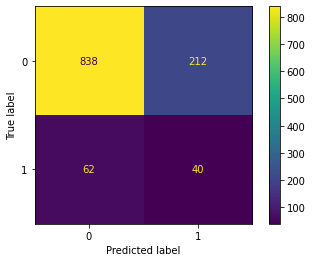

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

### Experiment extended on the whole HOLLISTER 

In [ ]:
# for i in range(118):
#     ds_temp = ds_o.iloc[i*12:(i+3)*12]
#     tr, te = ds_temp[:24], ds_temp[24:]
#     X_train = tr[['OPR_HR', 'OPR_INTERVAL']]
#     y_train = tr['outlier']

#     X_test = te[['OPR_HR', 'OPR_INTERVAL']]
#     y_test = te['outlier']

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

In [ ]:
# Number of Outliers in each day
#2022-03-19 - 2022-03-23
# for i in dates_outliers:
#     print(i, ' - ', (hol[hol.OPR_DT == i].MW > 200).sum())

In [ ]:
# ds_for_damming = dam[(dam['OPR_DT'] >= hol['OPR_DT'].unique()[0]) & (dam['OPR_DT'] <= hol['OPR_DT'].unique()[-1])]   # all dates are as in HOL

# dates = ['2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09', 
# '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17']
# pdList = []

# for n in ds_for_damming['OPR_DT'].unique():
#     for lmp in [0, 1, 2, 3]:
#         pdList.append(add_dam(lmp, dates[-1], n, hol, ds_for_damming))
# new_df = pd.concat(pdList)

In [ ]:
# To check add_dam_new()
# s = dam[dam['OPR_DT'] == '2022-06-17']
# s[s['LMP_TYPE'] == 3]
# s = hol[hol['OPR_DT'] == '2022-06-10']
# s[s['LMP_TYPE'] == 0].head(2)

In [ ]:
days_in_x = 7
all_dates = hol['OPR_DT'].unique()
mae_dam = []
for n in range(140):
    start = all_dates[n]
    end = all_dates[n + days_in_x]
    if ds_for_damming[ds_for_damming['OPR_DT'] == end].shape[0] == 96:
        new_dates = pd.date_range(start,end,freq='d')
        df_dam = add_dam_new(new_dates, new_dates[-1], hol, ds_for_damming)
        mae_dam.append(train_test(df_dam, end))
        print(mae_dam[-1])

In [122]:
# why this shape is 32???
# 2022-02-14 is 64, MUST BE 96
# 2 дня в середине и 2 последних два месяца всегда с неправильным шейпом, почему?
ds_for_damming[ds_for_damming['OPR_DT'] == '2022-02-15'].shape
# for n in range(9, 140):
#     print(all_dates[n], '-', ds_for_damming[ds_for_damming['OPR_DT'] == all_dates[n]].shape)

(32, 4)

In [ ]:
days_in_x = 7
all_dates = hol['OPR_DT'].unique()
mae_without_dam = []
for n in range(140):
    
    start = all_dates[n]
    end = all_dates[n + days_in_x]
    if ds_for_damming[ds_for_damming['OPR_DT'] == end].shape[0] == 96:
        new_df = hol[(hol['OPR_DT'] >= start) & (hol['OPR_DT'] <= end)]

        mae_without_dam.append(train_test(new_df, end))
        # print(mae_without_dam[-1])

In [88]:
days_in_x = 4
all_dates = hol['OPR_DT'].unique()
mae_dam_4 = []
for n in range(140):
    start = all_dates[n]
    end = all_dates[n + days_in_x]
    if ds_for_damming[ds_for_damming['OPR_DT'] == end].shape[0] == 96:
        new_dates = pd.date_range(start,end,freq='d')
        df_dam = add_dam_new(new_dates, new_dates[-1], hol, ds_for_damming)
        mae_dam_4.append(train_test(df_dam, end))

In [89]:
days_in_x = 4
all_dates = hol['OPR_DT'].unique()
mae_without_dam_4 = []
for n in range(140):
    
    start = all_dates[n]
    end = all_dates[n + days_in_x]
    if ds_for_damming[ds_for_damming['OPR_DT'] == end].shape[0] == 96:
        new_df = hol[(hol['OPR_DT'] >= start) & (hol['OPR_DT'] <= end)]

        mae_without_dam_4.append(train_test(new_df, end))

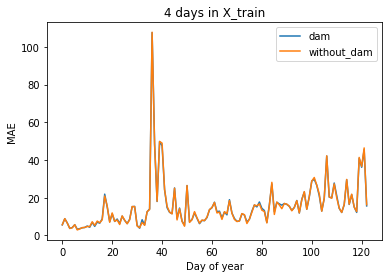

In [107]:
xlab = range(len(mae_dam_4))
plt.plot(xlab, mae_dam_4, label='dam')
plt.plot(xlab, mae_without_dam_4, label='without_dam')
plt.legend()
plt.title('4 days in X_train')
plt.ylabel('MAE')
plt.xlabel('Day of year')
plt.show()

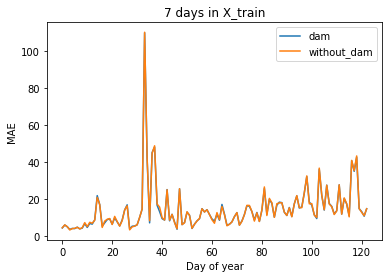

In [108]:
xlab = range(len(mae_dam))
plt.plot(xlab, mae_dam, label='dam')
plt.plot(xlab, mae_without_dam, label='without_dam')
plt.legend()
plt.title('7 days in X_train')
plt.ylabel('MAE')
plt.xlabel('Day of year')
plt.show()

In [121]:
print('MAE on 120 cases:')
print('With DAM 7 days in X - ', np.mean(mae_dam))
print('WithOUT DAM 7 days in X - ', np.mean(mae_without_dam))

print('With DAM 4 days in X - ', np.mean(mae_dam_4))
print('WithOUT DAM 4 days in X - ', np.mean(mae_without_dam_4))

MAE on 120 cases:
With DAM 7 days in X -  14.533463323453027
WithOUT DAM 7 days in X -  14.591461047857736
With DAM 4 days in X -  15.496514960274109
WithOUT DAM 4 days in X -  15.450838810238116


In [110]:
best_list = []
list_of_days_in_x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

all_dates = hol['OPR_DT'].unique()
for days_in_x in list_of_days_in_x:
    mae_find_best = []
    for n in range(140):
        start = all_dates[n]
        end = all_dates[n + days_in_x]
        if ds_for_damming[ds_for_damming['OPR_DT'] == end].shape[0] == 96:
            new_df = hol[(hol['OPR_DT'] >= start) & (hol['OPR_DT'] <= end)]

            mae_find_best.append(train_test(new_df, end))
    best_list.append(np.mean(mae_find_best))
    print(days_in_x)

2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
# list_of_days_in_x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
#best_list = [16.017560036740626,
 15.808288688413926,
 15.463641365751329,
 15.14688521919638,
 14.904048221846416,
 14.592532844131094,
 14.517865767174092,
 14.646850386708167,
 14.83210172429097,
 14.945354529503128,
 14.99498187507174,
 15.06610712352036]

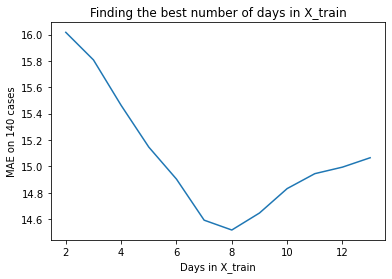

In [117]:
plt.plot(list_of_days_in_x, best_list);
plt.title('Finding the best number of days in X_train')
plt.ylabel('MAE on 140 cases')
plt.xlabel('Days in X_train')
plt.show()

In [ ]:
# ss = hol.groupby(hol.OPR_DT).mean().MW
# plt.plot(all_dates[:140], ss[:140], label='Mean values from HOLLISTER')
# plt.plot(all_dates[:140], mae_without_dam, label='MAE, 7 days in X_train')
# plt.legend()
# plt.show()

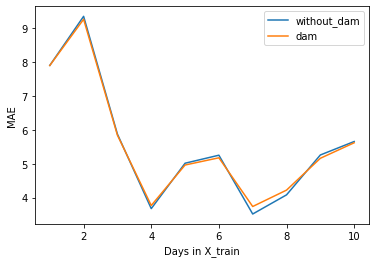

In [69]:
xlab = range(1, len(dates))
plt.plot(xlab, mae_without_dam, label='without_dam')
plt.plot(xlab, mae, label='dam')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Days in X_train')
plt.show()

вывести feature_importance

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decompose_data = seasonal_decompose(hol, model="additive")
# decompose_data.plot();

## Trash

In [8]:
pdList = []

dates = ['2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06', '2022-02-07']#, '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12',
# '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17']

for n in dates:
    for lmp in [0, 1, 2, 3]:
        pdList.append(add_dam(lmp, dates[-1], n, hol, dam))
new_df = pd.concat(pdList)
train_test(new_df, dates)

3.6086489060329865

Number of outliers > 200$ is
 0


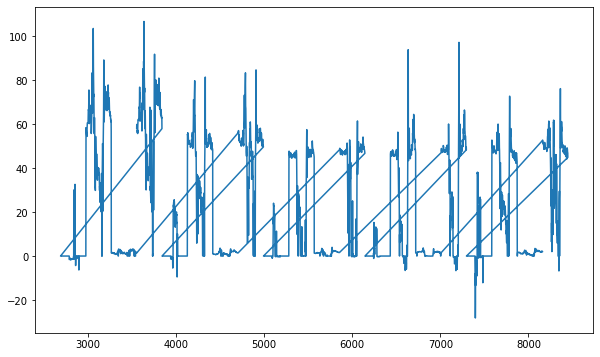

In [9]:
print('Number of outliers > 200$ is\n', (new_df.MW > 200).sum())
plt.figure(figsize=(10, 6))
plt.plot(new_df.MW);

### Trash

In [219]:
exp = dam[dam['OPR_DT'] == '2022-02-01']  
exp = exp[exp['LMP_TYPE'] == 'LMP']  #.sort_values('OPR_HR')
ee = exp[['OPR_HR', 'MW']]

sec = hol[hol['OPR_DT'] == '2022-02-01']
sec = sec[sec['LMP_TYPE'] == 'LMP']
lis = []

for i in sec['OPR_HR']:
    lis.append(ee[ee['OPR_HR'] == i]['MW'].values)
sec['dam'] = np.hstack(lis)
sec


,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,LMP_TYPE,MW,OPR_INTERVAL,GROUP,dam
1248,2022-02-01T08:00:00-00:00,2022-02-01T08:05:00-00:00,2022-02-01,1,LMP,51.52587,1,8,50.41301
1249,2022-02-01T08:05:00-00:00,2022-02-01T08:10:00-00:00,2022-02-01,1,LMP,51.59934,2,8,50.41301
1250,2022-02-01T08:10:00-00:00,2022-02-01T08:15:00-00:00,2022-02-01,1,LMP,50.37979,3,8,50.41301
1251,2022-02-01T08:15:00-00:00,2022-02-01T08:20:00-00:00,2022-02-01,1,LMP,49.25534,4,8,50.41301
1252,2022-02-01T08:20:00-00:00,2022-02-01T08:25:00-00:00,2022-02-01,1,LMP,49.37044,5,8,50.41301
...,...,...,...,...,...,...,...,...,...
1531,2022-02-02T07:35:00-00:00,2022-02-02T07:40:00-00:00,2022-02-01,24,LMP,65.95402,8,8,52.80506
1532,2022-02-02T07:40:00-00:00,2022-02-02T07:45:00-00:00,2022-02-01,24,LMP,64.11099,9,8,52.80506
1533,2022-02-02T07:45:00-00:00,2022-02-02T07:50:00-00:00,2022-02-01,24,LMP,62.95589,10,8,52.80506
1534,2022-02-02T07:50:00-00:00,2022-02-02T07:55:00-00:00,2022-02-01,24,LMP,66.74740,11,8,52.80506


In [ ]:
for i in range(1, 69):
    print('Group {}\n'.format(i), hol[hol.GROUP == i].OPR_DT.unique())

# for i in range(1, 86):
#     print('Group {}\n'.format(i), dam[dam.GROUP == i].OPR_DT.unique())

In [2]:
df = pd.read_csv('20220715_20220729_PRC_INTVL_LMP_RTM_20220731_05_17_54_v3.csv')
df.drop(df[df.LMP_TYPE == 'MGHG'].index, axis=0, inplace=True)

trash = ['NODE_ID_XML', 'NODE_ID', 'NODE', 'MARKET_RUN_ID', 'PNODE_RESMRID', 'GRP_TYPE', 'POS']
df.drop(trash, axis=1, inplace=True)
df.drop('XML_DATA_ITEM', axis=1, inplace=True)                      # Because it's 100% correlated with LMP_TYPE

date = ['INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT',	'OPR_DT', 'GROUP']

# date = ['INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT',	'OPR_DT']   # Because OPR_HR and OPR_INTERVAL contain it.
# df.drop(date, axis=1, inplace=True)

# 07:00 - 08:00    OPR_HR == 1
# 08:00 - 09:00    OPR_HR == 2
# 15:00 - 16:00    OPR_HR == 9
# 22:00 - 23:00    OPR_HR == 16

# 07:00 - 07:05    OPR_INTERVAL == 1

# df.XML_DATA_ITEM.unique() == ['LMP_CONG_PRC', 'LMP_ENE_PRC', 'LMP_GHG_PRC', 'LMP_LOSS_PRC', 'LMP_PRC']
# df.LMP_TYPE.unique() == ['MCC', 'MCE', 'MGHG', 'MCL', 'LMP']

In [3]:
le = LabelEncoder()
le.fit(['MCC', 'MCE', 'MCL', 'LMP'])   #  'MGHG' leads to VALUE == 0

df['lmp_trans'] = le.transform(df.LMP_TYPE)
df.drop('LMP_TYPE', axis=1, inplace=True)
df

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,VALUE,OPR_INTERVAL,GROUP,lmp_trans
0,2022-07-15T15:00:00-00:00,2022-07-15T15:05:00-00:00,2022-07-15,9,20.05033,1,1,1
1,2022-07-15T15:05:00-00:00,2022-07-15T15:10:00-00:00,2022-07-15,9,25.44488,2,1,1
2,2022-07-15T15:10:00-00:00,2022-07-15T15:15:00-00:00,2022-07-15,9,27.20417,3,1,1
3,2022-07-15T15:15:00-00:00,2022-07-15T15:20:00-00:00,2022-07-15,9,19.84158,4,1,1
4,2022-07-15T15:20:00-00:00,2022-07-15T15:25:00-00:00,2022-07-15,9,19.88617,5,1,1
...,...,...,...,...,...,...,...,...
20635,2022-07-29T22:35:00-00:00,2022-07-29T22:40:00-00:00,2022-07-29,16,100.00000,8,75,0
20636,2022-07-29T22:40:00-00:00,2022-07-29T22:45:00-00:00,2022-07-29,16,104.37120,9,75,0
20637,2022-07-29T22:45:00-00:00,2022-07-29T22:50:00-00:00,2022-07-29,16,118.12000,10,75,0
20638,2022-07-29T22:50:00-00:00,2022-07-29T22:55:00-00:00,2022-07-29,16,121.00000,11,75,0


Try models

In [4]:
def days(d, n):
    '''
    Returns the appropriate number of days to form the train dataset in ahead() function.

    d - number of days you want to include in X_train,
    n - number of the group you want to start from. Should be in [6, 11, 16, 21, 26, 31, 36, 41].
    '''
    if d == 1:
        return [n, n+1, n+3, n+4]                                       # First day

    elif d == 2:
        return [n, n+1, n+3, n+4,                                       # First day
                n+5, n+6, n+8, n+9]                                     # Second day

    elif d == 3:
        return [n, n+1, n+3, n+4,                                       # First day
                n+5, n+6, n+8, n+9,                                     # Second day
                n+10, n+11, n+13, n+14]                                 # Third day

    elif d == 4:
        return [n, n+1, n+3, n+4,                                       # First day
                n+5, n+6, n+8, n+9,                                     # Second day
                n+10, n+11, n+13, n+14,                                 # Third day
                n+15, n+16, n+18, n+19]                                 # Fourth day        

    elif d == 5:
        return [n, n+1, n+3, n+4,                                       # First day
                n+5, n+6, n+8, n+9,                                     # Second day
                n+10, n+11, n+13, n+14,                                 # Third day
                n+15, n+16, n+18, n+19,                                 # Fourth day 
                n+20, n+21, n+23, n+24]                                 # Fifth day

    elif d == 6:
        return [n, n+1, n+3, n+4,                                       # First day
                n+5, n+6, n+8, n+9,                                     # Second day
                n+10, n+11, n+13, n+14,                                 # Third day
                n+15, n+16, n+18, n+19,                                 # Fourth day 
                n+20, n+21, n+23, n+24,                                 # Fifth day
                n+25, n+26, n+28, n+29]                                 # Sixth day    
    
    else: return 'Please enter d in [1:6], or extend the list manually, or ask me (Artem) to do it. I have not made it for d>6 yet'

In [5]:
def ahead(n, d, df, date):
    '''
    Makes train and test datasets and returns MAE.

    n - number of the group you want to start from. Should be in [6, 11, 16, 21, 26, 31, 36, 41],
    d - number of days you want to include in X_train,
    df - preprocessed dataset,
    date - columns to be dropped.
    '''
    train_df = df.loc[df.GROUP.isin(days(d, n))]

    train_df.drop(date, axis=1, inplace=True)
    y_train = train_df.VALUE
    X_train = train_df.drop('VALUE', axis=1)

    n = n+5*d                                               
    test_df = df.loc[df.GROUP.isin([n, n+1, n+3, n+4])]

    test_df.drop(date, axis=1, inplace=True)
    y_test = test_df.VALUE
    X_test = test_df.drop('VALUE', axis=1)

    forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='absolute_error')
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

In [6]:
nn = [6, 11, 16, 21, 26, 31, 36]
res_4 = []
for i in nn:
    res_4.append(ahead(i, 4, df, date))

print('X_train consists of 4 days. The X_train starts to be formed from group == i.\nMAE for each case:', res_4)
print('Mean MAE =', np.mean(res_4))

X_train consists of 4 days. The X_train starts to be formed from group == i.
MAE for each case: [9.365727257595488, 10.983961937282986, 8.571848083116318, 13.709818090060764, 9.343416546657986, 11.585021109157985, 10.23405539171007]
Mean MAE = 10.541978345083084


In [11]:
nn = [6, 11, 16, 21, 26, 31]
res_6 = []
for i in nn:
    res_6.append(ahead(i, 6, df, date))

print('X_train consists of 6 days. The X_train starts to be formed from group == i.\nMAE for each case:', res_6)
print('Mean MAE =', np.mean(res_6))
print('Mean MAE without the possible outlier =', np.mean(res_6[:-1]))
# Something is wrong when we have 6 days in X and start from group=31. I think it's an outlier, but should be checked properly on a broader dataset.

X_train consists of 6 days. The X_train starts to be formed from group == i.
MAE for each case: [7.356427351128472, 13.037939217881943, 10.148298914496527, 10.340709250868056, 9.639224867838541, 33.41474239301216]
Mean MAE = 13.989556999204282
Mean MAE without the possible outlier = 10.104519920442709


In [12]:
# Here you may play with the number of days included in X. As in cells above.
d = 6
ahead(6, d, df, date)

7.47863863780382

### Trash. Old cells.

XGBRegressor

In [118]:
# 4 days
xgbr = xgb.XGBRegressor(n_jobs=-1, random_state=1)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
mean_absolute_error(y_test, y_pred)

14.61164321677803

DecisionTreeRegressor

In [113]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
mean_absolute_error(y_test, y_pred)

11.426156106770833

RandomForestRegressor

In [109]:
forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='absolute_error')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
mean_absolute_error(y_test, y_pred)

7.367309338975695

### TRASH (function separately)

In [ ]:
n= 6
train_df = df.loc[df.GROUP.isin([n, n+1, n+3, n+4,
n+5, n+6, n+8, n+9,
n+10, n+11, n+13, n+14,
n+15, n+16, n+18, n+19
])]


In [ ]:
train_df.drop(date, axis=1, inplace=True)
y_train = train_df.VALUE

X_train = train_df.drop('VALUE', axis=1)
X_train

,OPR_HR,OPR_INTERVAL,lmp_trans
960,1,1,1
961,1,2,1
962,1,3,1
963,1,4,1
964,1,5,1
...,...,...,...
6715,24,8,0
6716,24,9,0
6717,24,10,0
6718,24,11,0


In [ ]:
n = 26
test_df = df.loc[(df.GROUP == n) | (df.GROUP == n+1) | (df.GROUP == n+3) | (df.GROUP == n+4)]
test_df

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,VALUE,OPR_INTERVAL,GROUP,lmp_trans
6720,2022-07-20T07:00:00-00:00,2022-07-20T07:05:00-00:00,2022-07-20,1,28.24952,1,26,1
6721,2022-07-20T07:05:00-00:00,2022-07-20T07:10:00-00:00,2022-07-20,1,28.25028,2,26,1
6722,2022-07-20T07:10:00-00:00,2022-07-20T07:15:00-00:00,2022-07-20,1,28.55085,3,26,1
6723,2022-07-20T07:15:00-00:00,2022-07-20T07:20:00-00:00,2022-07-20,1,29.18123,4,26,1
6724,2022-07-20T07:20:00-00:00,2022-07-20T07:25:00-00:00,2022-07-20,1,30.27590,5,26,1
...,...,...,...,...,...,...,...,...
8155,2022-07-21T06:35:00-00:00,2022-07-21T06:40:00-00:00,2022-07-20,24,93.32284,8,30,0
8156,2022-07-21T06:40:00-00:00,2022-07-21T06:45:00-00:00,2022-07-20,24,93.23081,9,30,0
8157,2022-07-21T06:45:00-00:00,2022-07-21T06:50:00-00:00,2022-07-20,24,93.50460,10,30,0
8158,2022-07-21T06:50:00-00:00,2022-07-21T06:55:00-00:00,2022-07-20,24,96.36335,11,30,0


In [ ]:
test_df.drop(date, axis=1, inplace=True)
y_test = test_df.VALUE

X_test = test_df.drop('VALUE', axis=1)
X_test

,OPR_HR,OPR_INTERVAL,lmp_trans
6720,1,1,1
6721,1,2,1
6722,1,3,1
6723,1,4,1
6724,1,5,1
...,...,...,...
8155,24,8,0
8156,24,9,0
8157,24,10,0
8158,24,11,0


In [ ]:
forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='absolute_error')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
mean_absolute_error(y_test, y_pred)

9.171129801432292